## Implementation of a Logistic Regression Model using Tensorflow and Keras

In [1]:
# Importing the required modules
import pandas as pd
import numpy as np
import seaborn as sb
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.estimator import LinearClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(tf.__version__)

2.0.0


### Loading and configuring the Iris dataset

In [2]:
col_names = ['SepalLength', 'SepalWidth', 'PetalLegth', 'PetalWidth', 'Species']
target_dimensions = ['Setosa', 'Versicolor', 'Virginica']
training_data_path = tf.keras.utils.get_file('iris_training.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv')
test_data_path = tf.keras.utils.get_file('iris_test.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv')

training = pd.read_csv(training_data_path, names=col_names, header=0)
training = training[training['Species'] >= 1]
training['Species'] = training['Species'].replace([1,2], [0,1])
test = pd.read_csv(test_data_path, names=col_names, header=0)
test = test[test['Species'] >= 1]
test['Species'] = test['Species'].replace([1,2], [0,1])

training.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
iris_dataset = pd.concat([training, test], axis=0)
iris_dataset.describe()

,SepalLength,SepalWidth,PetalLegth,PetalWidth,Species
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,6.262000,2.872000,4.906000,1.676000,0.500000
std,0.662834,0.332751,0.825578,0.424769,0.502519
min,4.900000,2.000000,3.000000,1.000000,0.000000
25%,5.800000,2.700000,4.375000,1.300000,0.000000
50%,6.300000,2.900000,4.900000,1.600000,0.500000
75%,6.700000,3.025000,5.525000,2.000000,1.000000
max,7.900000,3.800000,6.900000,2.500000,1.000000


### Checking  the relation between the variables  using pairplot and a correlation graph

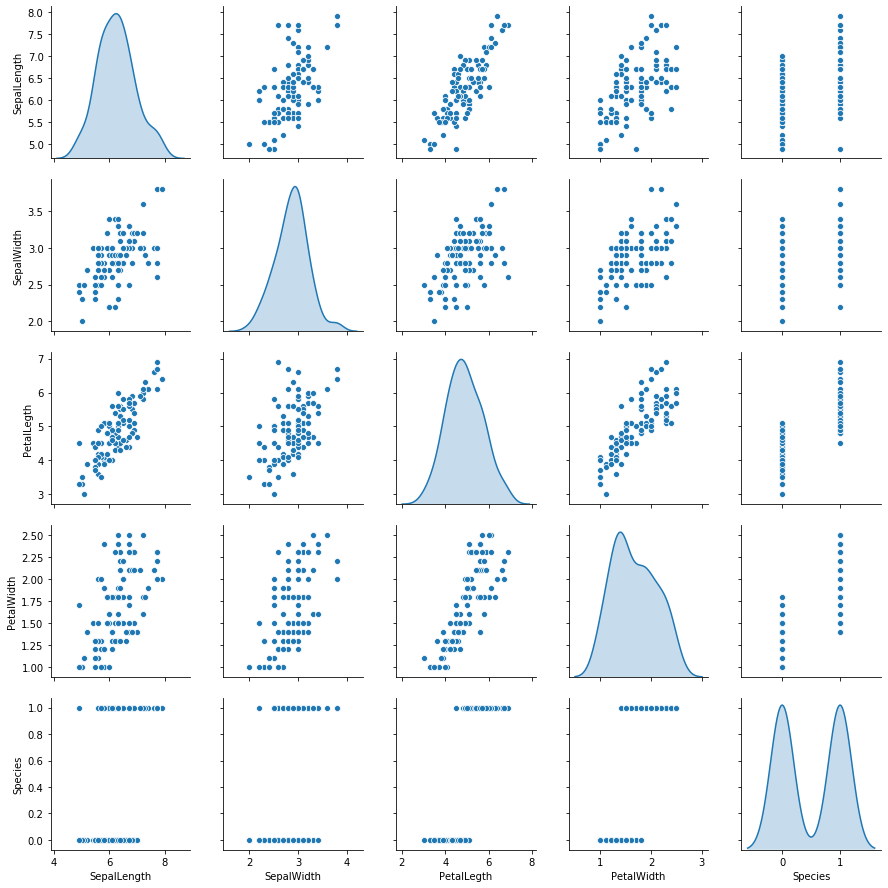

In [3]:
sb.pairplot(iris_dataset, diag_kind="kde")

In [4]:
correlation_data = iris_dataset.corr()
correlation_data.style.background_gradient(cmap='coolwarm', axis=None)

,SepalLength,SepalWidth,PetalLegth,PetalWidth,Species
SepalLength,1,0.553855,0.828479,0.593709,0.494305
SepalWidth,0.553855,1,0.519802,0.566203,0.30808
PetalLegth,0.828479,0.519802,1,0.823348,0.786424
PetalWidth,0.593709,0.566203,0.823348,1,0.828129
Species,0.494305,0.30808,0.786424,0.828129,1


### Descriptive statistics. Central tendency  and dispersion

In [5]:
stats = iris_dataset.describe()
iris_stats = stats.transpose()
iris_stats

,count,mean,std,min,25%,50%,75%,max
SepalLength,100.0,6.262,0.662834,4.9,5.800,6.3,6.700,7.9
SepalWidth,100.0,2.872,0.332751,2.0,2.700,2.9,3.025,3.8
PetalLegth,100.0,4.906,0.825578,3.0,4.375,4.9,5.525,6.9
PetalWidth,100.0,1.676,0.424769,1.0,1.300,1.6,2.000,2.5
Species,100.0,0.500,0.502519,0.0,0.000,0.5,1.000,1.0


### Selecting the required columns

In [6]:
X_data = iris_dataset[[i for i in iris_dataset.columns
                      if i not in ['Species']]]
y_data = iris_dataset[['Species']]

### Train and test split

In [7]:
training_features, test_features, training_labels, test_labels = train_test_split(X_data, y_data, test_size=0.2)
print('No. of rows in Training Features: ', training_features.shape[0])
print('No. of rows in Test Features: ', test_features.shape[0])
print('No. of columns in Training Features: ', training_features.shape[1])
print('No. of columns in Test Features: ', test_features.shape[1])
print('No. of rows in Training Labels: ', training_labels.shape[0])
print('No. of rows in Test Labels: ', test_labels.shape[0])
print('No. of columns in Training Labels: ', training_labels.shape[1])
print('No. of columns in Test Labels: ', test_labels.shape[1])

No. of rows in Training Features:  80
No. of rows in Test Features:  20
No. of columns in Training Features:  4
No. of columns in Test Features:  4
No. of rows in Training Labels:  80
No. of rows in Test Labels:  20
No. of columns in Training Labels:  1
No. of columns in Test Labels:  1


### Normalizing the data

In [8]:
def norm(x):
    stats = x.describe()
    stats = stats.transpose()
    return (x - stats['mean']) / stats['std']

normed_train_features = norm(training_features)
normed_test_features = norm(test_features)

### Building the input pipeline for the Tensorflow model

In [9]:
def feed_input(features_dataframe, target_dataframe, num_of_epochs=10, shuffle=True, batch_size=32):
    def input_feed_function():
        dataset = tf.data.Dataset.from_tensor_slices((dict(features_dataframe), target_dataframe))
        if shuffle:
            dataset = dataset.shuffle(2000)
        dataset = dataset.batch(batch_size).repeat(num_of_epochs)
        return dataset
    return input_feed_function

In [10]:
train_feed_input = feed_input(normed_train_features, training_labels)
train_feed_input_testing = feed_input(normed_train_features, training_labels, num_of_epochs=1, shuffle=False)
test_feed_input = feed_input(normed_test_features, test_labels, num_of_epochs=1, shuffle=False)

### Model training

In [11]:
from tensorflow.estimator import BoostedTreesClassifier

feature_columns_numeric = [tf.feature_column.numeric_column(m) for m in training_features.columns]
btree_model = BoostedTreesClassifier(feature_columns=feature_columns_numeric, n_batches_per_layer=1)
btree_model.train(train_feed_input)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpniisv0px', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f78b80a57f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
If using Keras pass *_constra

### Making predictions

In [12]:
train_predictions = btree_model.predict(train_feed_input_testing)
test_predictions = btree_model.predict(test_feed_input)
train_predictions_series = pd.Series([p['classes'][0].decode('utf-8')
                                      for p in train_predictions])
test_predictions_series = pd.Series([p['classes'][0].decode('utf-8')
                                     for p in test_predictions])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpniisv0px/model.ckpt-29
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpniisv0px/model.ckpt-29
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [13]:
train_predictions_df = pd.DataFrame(train_predictions_series, columns=['predictions'])
test_predictions_df = pd.DataFrame(test_predictions_series, columns=['predictions'])
training_labels.reset_index(drop=True, inplace=True)
train_predictions_df.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)
test_predictions_df.reset_index(drop=True, inplace=True)
train_labels_with_predictions_df = pd.concat([training_labels, train_predictions_df], axis=1)
test_labels_with_predictions_df = pd.concat([test_labels, test_predictions_df], axis=1)

### Validation

In [14]:
def calculate_binary_class_scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred.astype('int64'))
    precision = precision_score(y_true, y_pred.astype('int64'),average='macro')
    recall = recall_score(y_true, y_pred.astype('int64'), average='macro')
    return accuracy, precision, recall

train_accuracy_score, train_precision_score, train_recall_score = calculate_binary_class_scores(
    training_labels, train_predictions_series)
test_accuracy_score, test_precision_score, test_recall_score = calculate_binary_class_scores(
    test_labels, test_predictions_series)

In [39]:
print('Training data accuracy (%)=', round(train_accuracy_score*100,2))
print('Training data precision (%)=', round(train_precision_score*100,2))
print('Training data recall (%)=', round(train_recall_score*100,2))
print('-'*50)
print('Test data accuracy (%)=', round(test_accuracy_score*100,2))
print('Test data precision (%)=', round(test_precision_score*100,2))
print('Test data recall (%)=', round(test_recall_score*100,2))

Training data accuracy (%)= 100.0
Training data precision (%)= 100.0
Training data recall (%)= 100.0
--------------------------------------------------
Test data accuracy (%)= 95.0
Test data precision (%)= 95.83
Test data recall (%)= 94.44
